# STROKE PREDICTION USING ADVANCED MACHINE LEARNING


In [1]:
# ==================== IMPORT LIBRARIES ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report,
                             precision_recall_curve, auc)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE

# Visualization Enhancement
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")

# Set style for professional visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)

import os
os.makedirs("visualization", exist_ok=True)

In [2]:
# ==================== CONFIGURATION ====================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Color scheme
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'danger': '#C73E1D',
    'warning': '#F4D35E'
}

print("="*70)
print("STROKE PREDICTION - ADVANCED ML PIPELINE")
print("="*70)


STROKE PREDICTION - ADVANCED ML PIPELINE


In [3]:
# ==================== DATA LOADING ====================
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
print(f"✓ Dataset loaded: {df.shape[0]} records, {df.shape[1]} features")


✓ Dataset loaded: 5110 records, 12 features


In [4]:
# ==================== EXPLORATORY DATA ANALYSIS ====================
# Display basic information
print("\n" + "-"*70)
print("DATASET OVERVIEW")
print("-"*70)

print(f"\nShape: {df.shape}")
print("_"*70)

print(f"\nData Types:\n{df.dtypes}")
print("_"*70)

print(f"\nMissing Values:\n{df.isnull().sum()}")
print("_"*70)

print(f"\nBasic Statistics:\n{df.describe()}")


----------------------------------------------------------------------
DATASET OVERVIEW
----------------------------------------------------------------------

Shape: (5110, 12)
______________________________________________________________________

Data Types:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object
______________________________________________________________________

Missing Values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke      

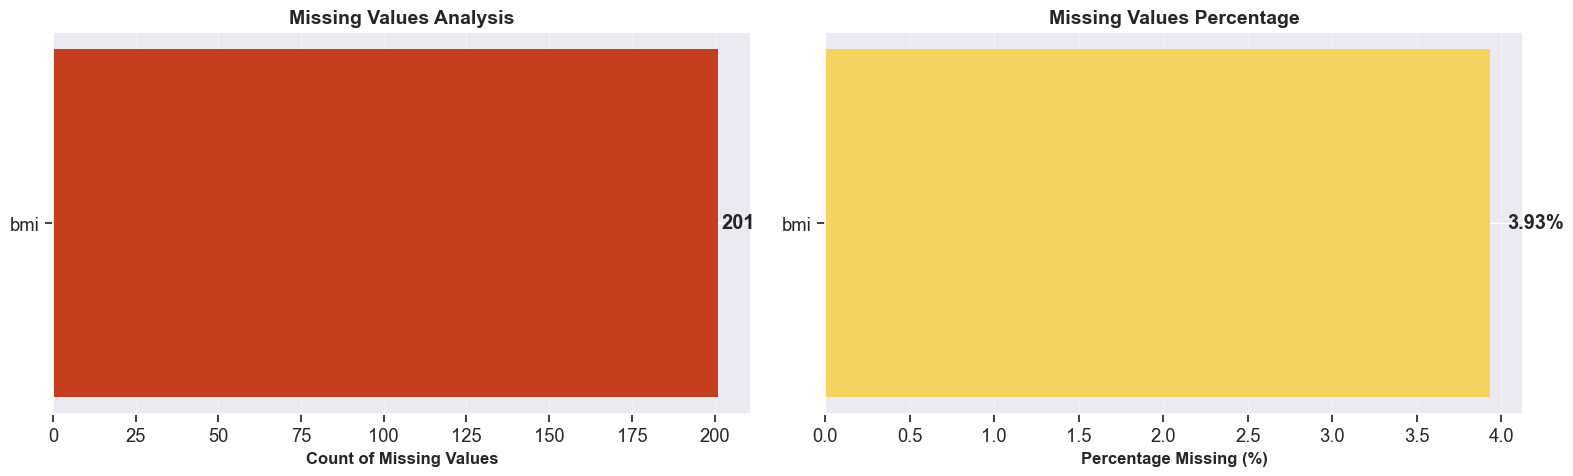

In [5]:
# ==================== VISUALIZATION 1: Missing Values ====================
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Missing values bar plot
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    axes[0].barh(missing.index, missing.values, color=COLORS['danger'])
    axes[0].set_xlabel('Count of Missing Values', fontsize=12, fontweight='bold')
    axes[0].set_title('Missing Values Analysis', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

    for i, v in enumerate(missing.values):
        axes[0].text(v + 1, i, str(v), va='center', fontweight='bold')
else:
    axes[0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=14)
    axes[0].axis('off')

# Missing percentage
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]
if len(missing_pct) > 0:
    axes[1].barh(missing_pct.index, missing_pct.values, color=COLORS['warning'])
    axes[1].set_xlabel('Percentage Missing (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Missing Values Percentage', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)

    for i, v in enumerate(missing_pct.values):
        axes[1].text(v + 0.1, i, f'{v:.2f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualization/01_missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# ==================== DATA PREPROCESSING ====================
# Remove ID column
df = df.drop(['id'], axis=1)

# Handle 'Other' gender
df['gender'] = df['gender'].replace('Other', 'Female')
print(f"✓ Gender categories standardized")

# Impute BMI with median
bmi_median = df['bmi'].median()
df['bmi'] = df['bmi'].fillna(bmi_median)
print(f"✓ BMI missing values imputed with median: {bmi_median:.2f}")

✓ Gender categories standardized
✓ BMI missing values imputed with median: 28.10


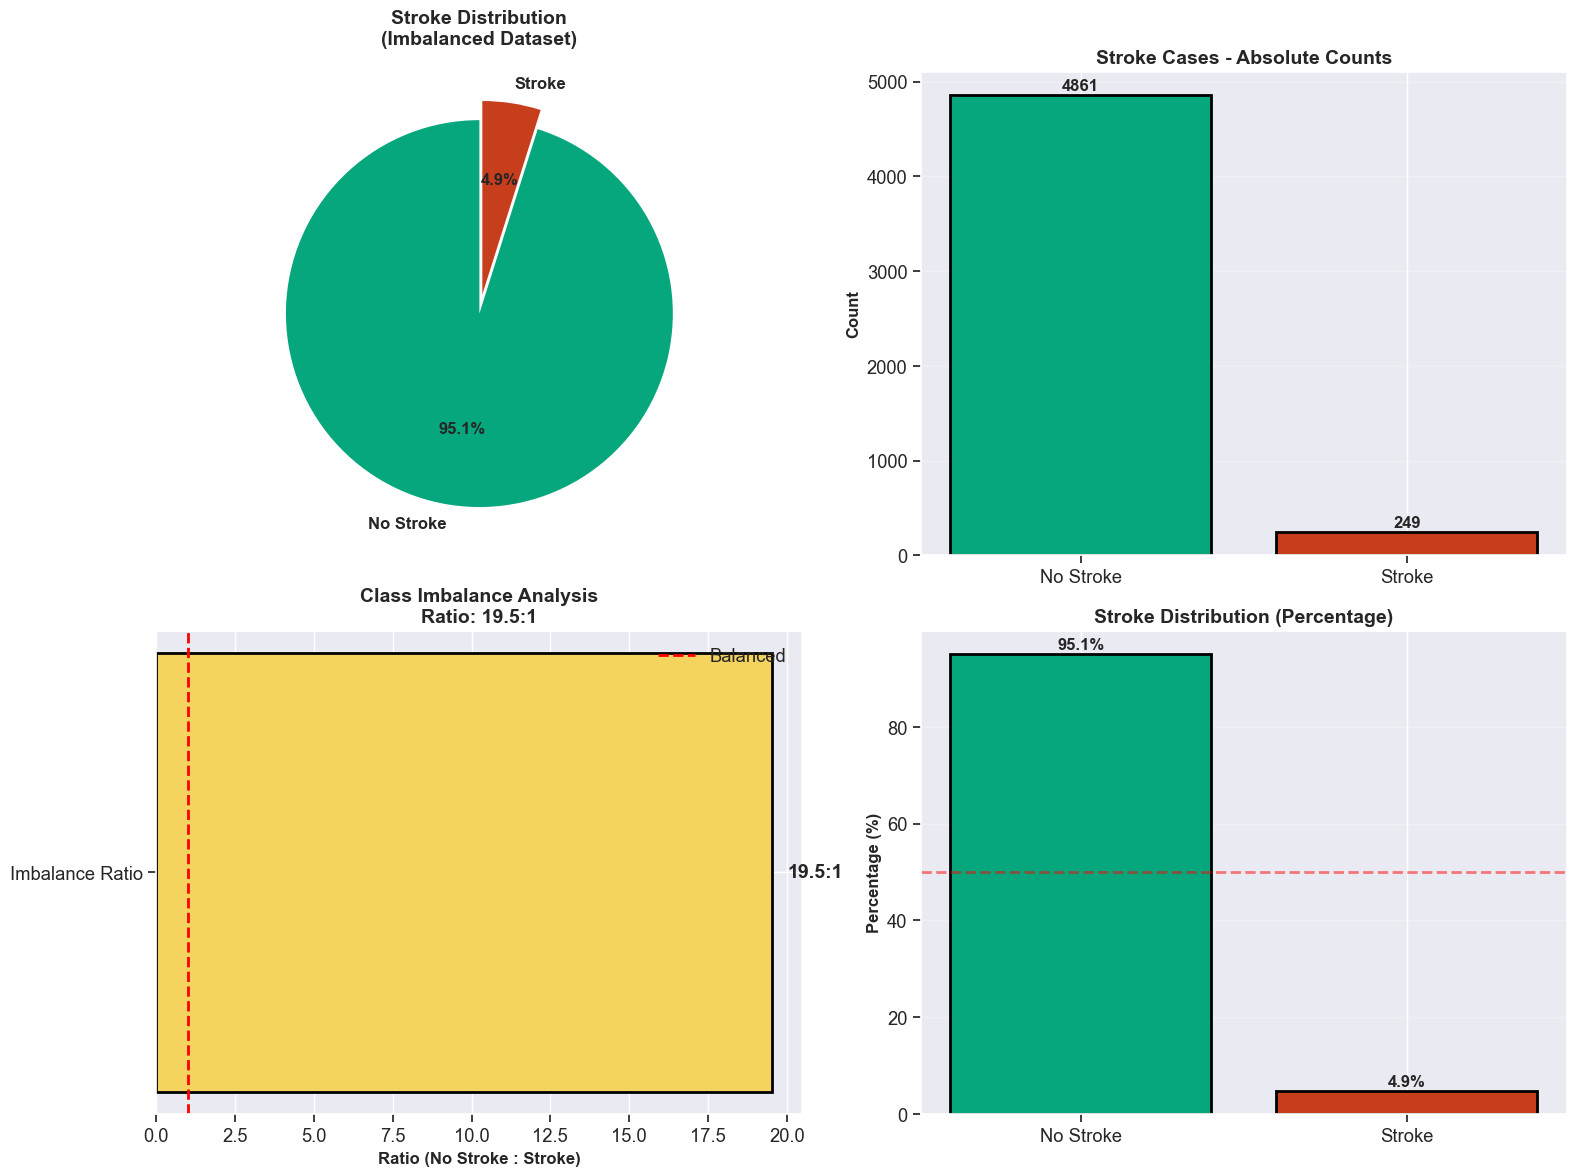


TARGET VARIABLE ANALYSIS
No Stroke: 4861 (95.13%)
Stroke: 249 (4.87%)
Imbalance Ratio: 19.52:1


In [7]:
# ==================== VISUALIZATION 2: Target Distribution ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Stroke distribution
stroke_counts = df['stroke'].value_counts()
colors_stroke = [COLORS['success'], COLORS['danger']]
axes[0, 0].pie(stroke_counts, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%',
               colors=colors_stroke, startangle=90, explode=(0, 0.1),
               textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0, 0].set_title('Stroke Distribution\n(Imbalanced Dataset)',
                      fontsize=14, fontweight='bold', pad=20)

# Bar chart with counts
axes[0, 1].bar(['No Stroke', 'Stroke'], stroke_counts.values, color=colors_stroke,
               edgecolor='black', linewidth=2)
axes[0, 1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Stroke Cases - Absolute Counts', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(stroke_counts.values):
    axes[0, 1].text(i, v + 50, str(v), ha='center', fontweight='bold', fontsize=12)

# Class imbalance ratio
imbalance_ratio = stroke_counts[0] / stroke_counts[1]
axes[1, 0].barh(['Imbalance Ratio'], [imbalance_ratio], color=COLORS['warning'],
                edgecolor='black', linewidth=2)
axes[1, 0].set_xlabel('Ratio (No Stroke : Stroke)', fontsize=12, fontweight='bold')
axes[1, 0].set_title(f'Class Imbalance Analysis\nRatio: {imbalance_ratio:.1f}:1',
                      fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=1, color='red', linestyle='--', linewidth=2, label='Balanced')
axes[1, 0].legend()
axes[1, 0].text(imbalance_ratio + 0.5, 0, f'{imbalance_ratio:.1f}:1',
                va='center', fontweight='bold', fontsize=14)

# Percentage breakdown
stroke_pct = (stroke_counts / stroke_counts.sum() * 100).values
axes[1, 1].bar(['No Stroke', 'Stroke'], stroke_pct, color=colors_stroke,
               edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Stroke Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5)
for i, v in enumerate(stroke_pct):
    axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('visualization/02_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*70}")
print(f"TARGET VARIABLE ANALYSIS")
print(f"{'='*70}")
print(f"No Stroke: {stroke_counts[0]} ({stroke_pct[0]:.2f}%)")
print(f"Stroke: {stroke_counts[1]} ({stroke_pct[1]:.2f}%)")
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")

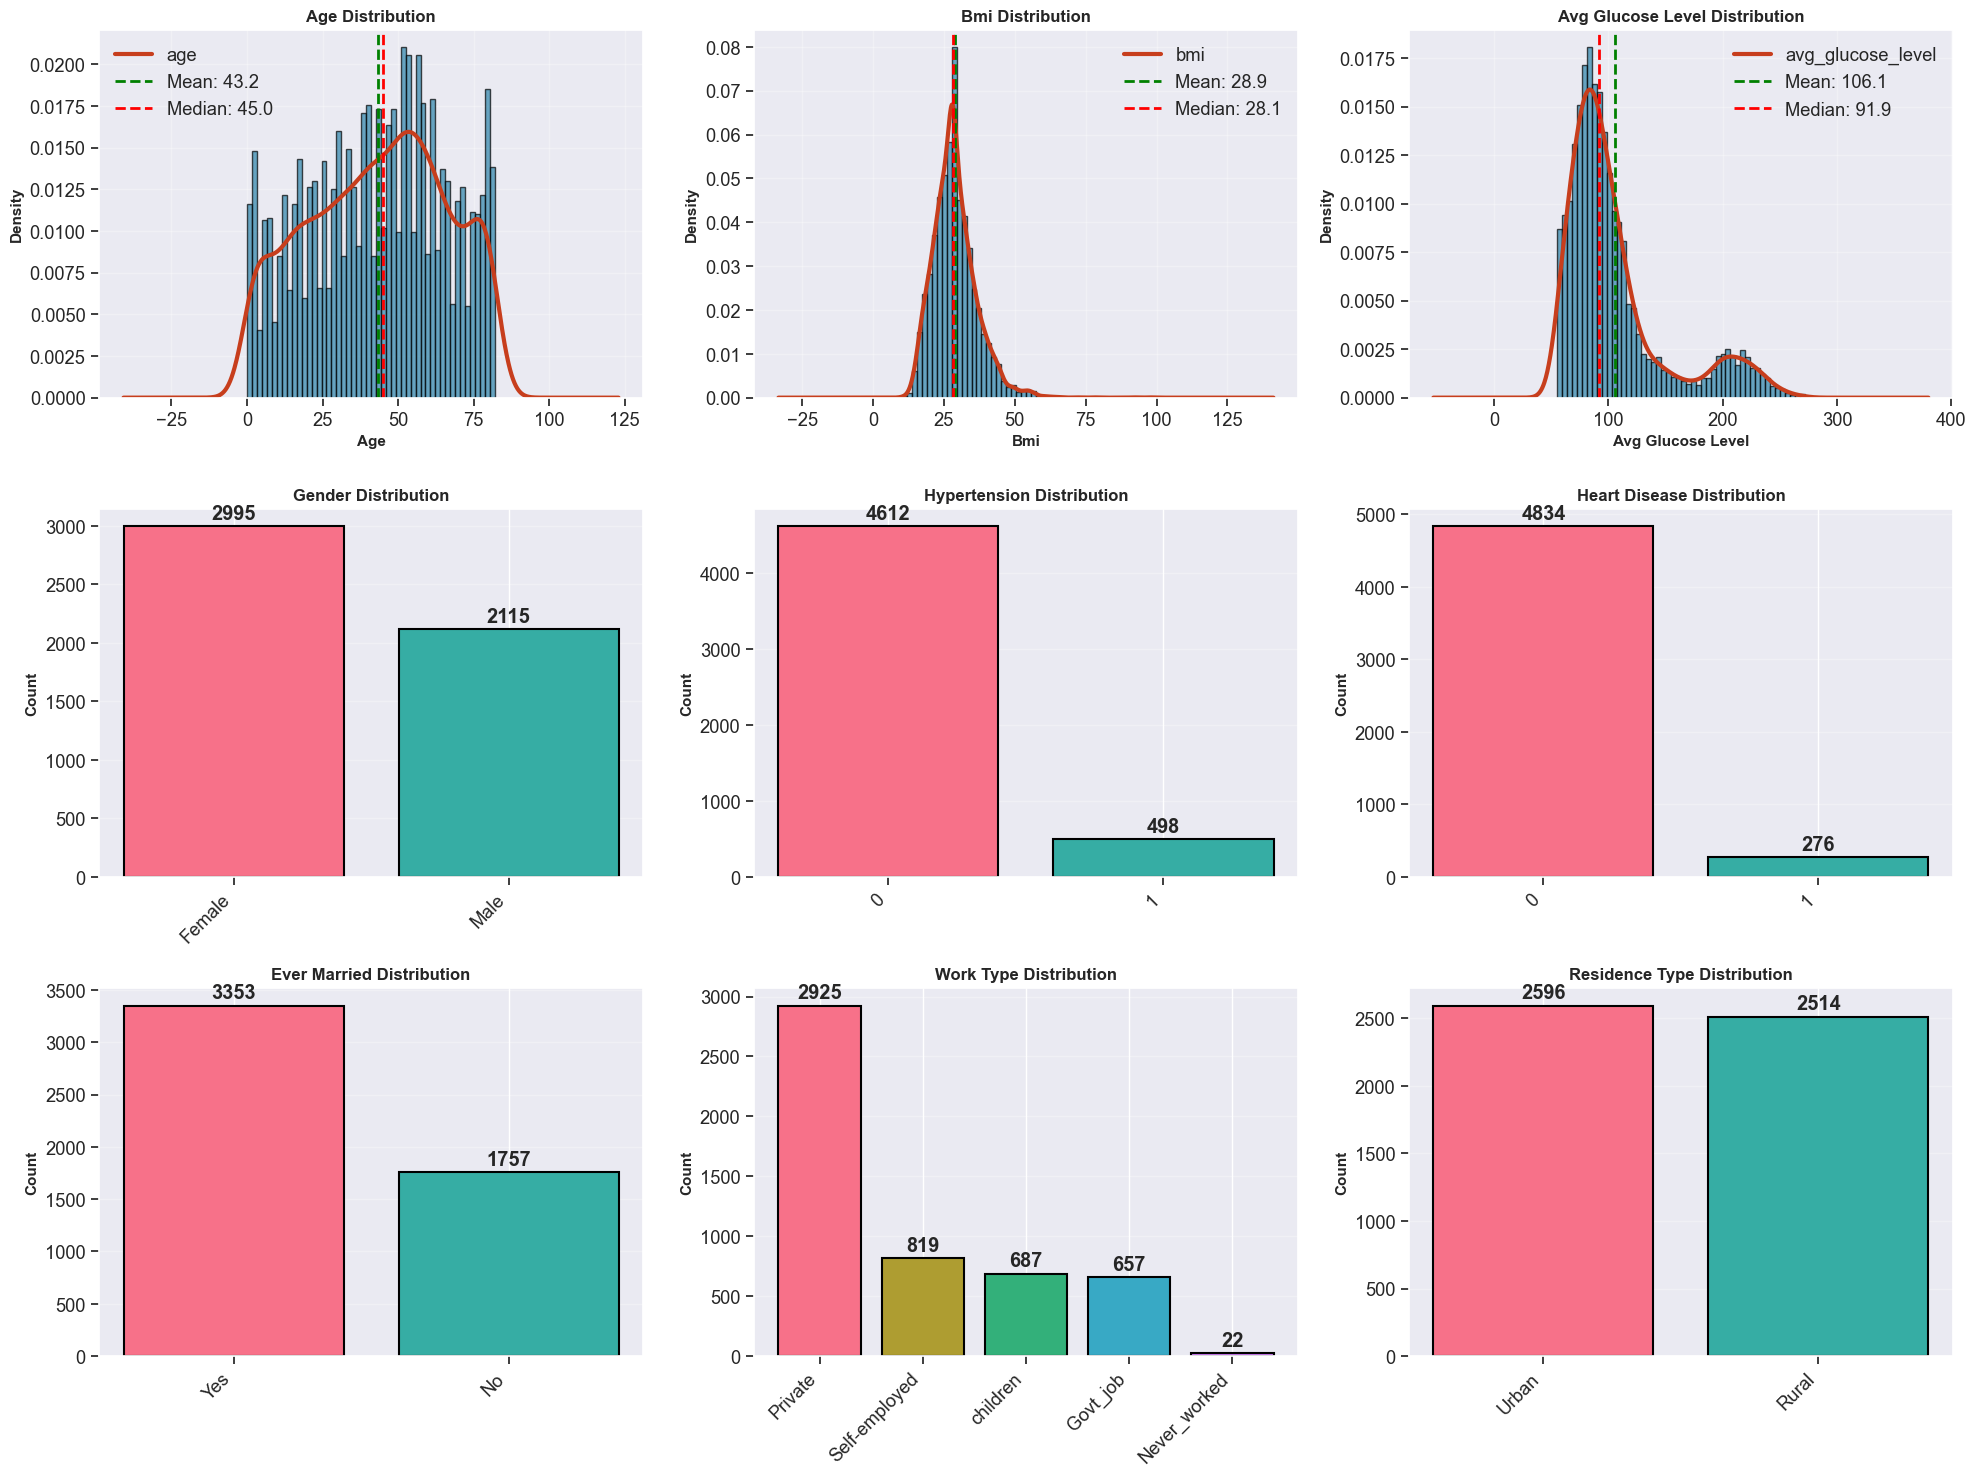

In [8]:
# ==================== VISUALIZATION 3: Feature Distributions ====================
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

# Numerical features
numerical_features = ['age', 'bmi', 'avg_glucose_level']
for idx, col in enumerate(numerical_features):
    # Histogram with KDE
    axes[idx].hist(df[col], bins=50, alpha=0.7, color=COLORS['primary'],
                   edgecolor='black', density=True)
    df[col].plot(kind='kde', ax=axes[idx], color=COLORS['danger'], linewidth=3)
    axes[idx].set_xlabel(col.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Density', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{col.replace("_", " ").title()} Distribution',
                        fontsize=12, fontweight='bold')
    axes[idx].grid(alpha=0.3)

    # Add statistics
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[idx].axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    axes[idx].axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    axes[idx].legend()

# Categorical features
categorical_features = ['gender', 'hypertension', 'heart_disease',
                        'ever_married', 'work_type', 'Residence_type']
for idx, col in enumerate(categorical_features, start=3):
    if idx < 9:
        value_counts = df[col].value_counts()
        colors_cat = sns.color_palette("husl", len(value_counts))
        axes[idx].bar(range(len(value_counts)), value_counts.values,
                      color=colors_cat, edgecolor='black', linewidth=1.5)
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[idx].set_ylabel('Count', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{col.replace("_", " ").title()} Distribution',
                           fontsize=12, fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)

        for i, v in enumerate(value_counts.values):
            axes[idx].text(i, v + max(value_counts.values)*0.02, str(v),
                          ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualization/03_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

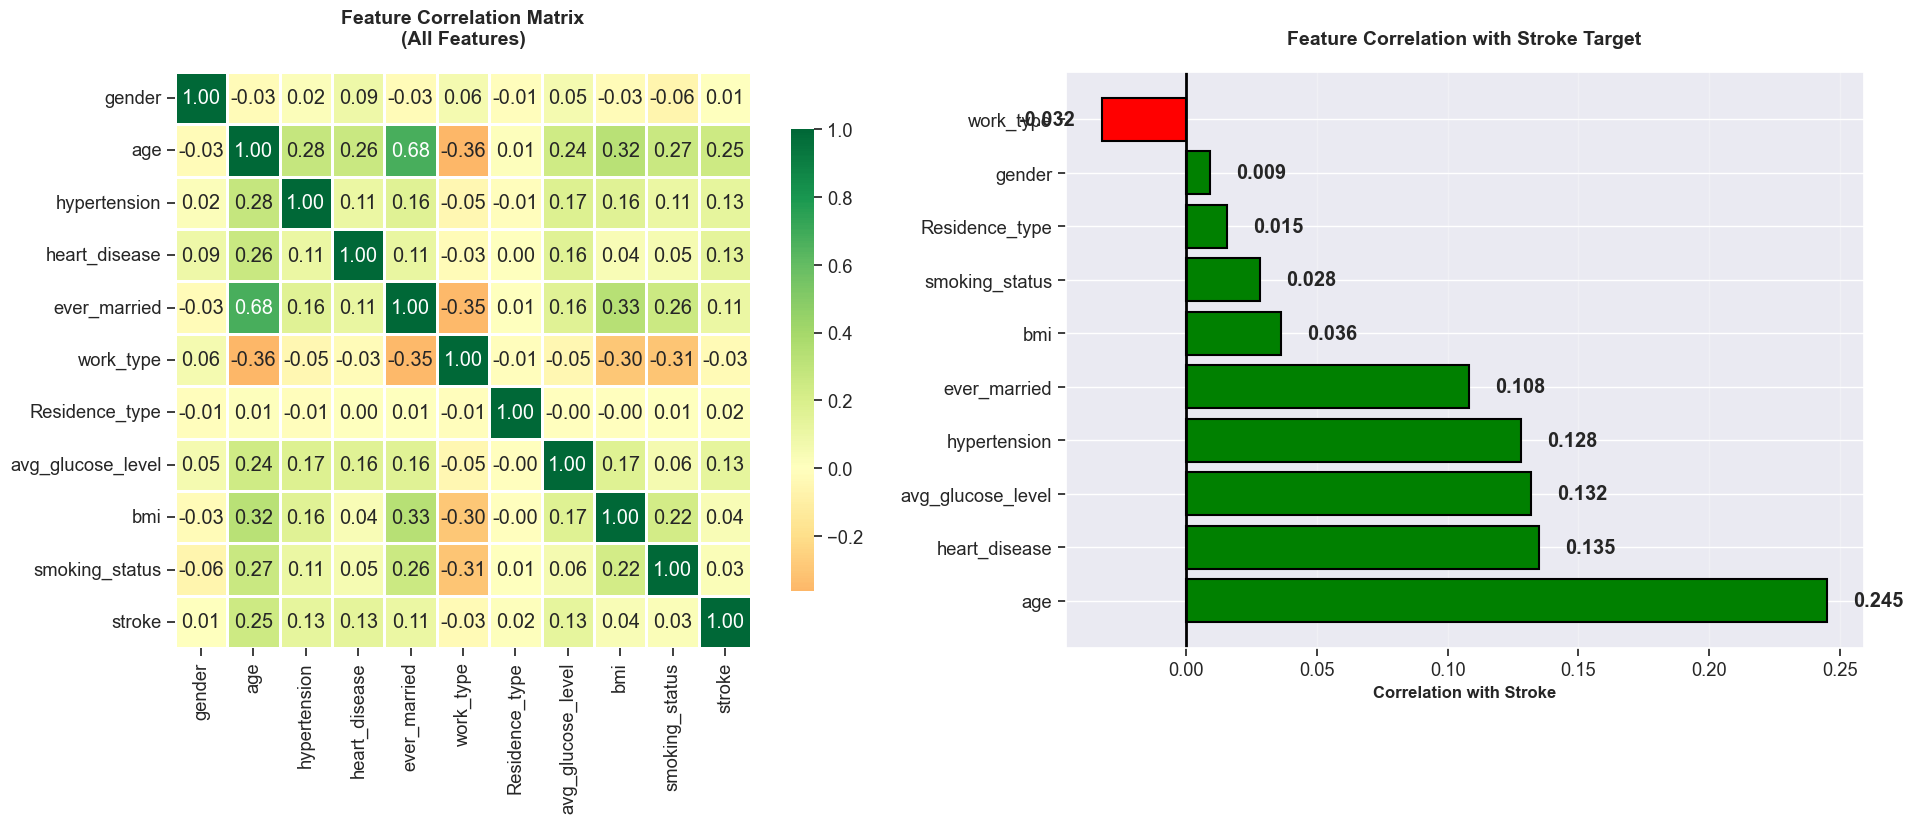

In [9]:
# ==================== VISUALIZATION 4: Correlation Analysis ====================
# Prepare data for correlation
df_corr = df.copy()
label_encoders = {}
for col in df_corr.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_corr[col] = le.fit_transform(df_corr[col])
    label_encoders[col] = le

# Correlation matrix
corr_matrix = df_corr.corr()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap 1: Full correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Feature Correlation Matrix\n(All Features)',
                  fontsize=14, fontweight='bold', pad=20)

# Heatmap 2: Stroke correlation
stroke_corr = corr_matrix['stroke'].sort_values(ascending=False).drop('stroke')
colors_corr = ['green' if x > 0 else 'red' for x in stroke_corr.values]
axes[1].barh(range(len(stroke_corr)), stroke_corr.values, color=colors_corr,
             edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(stroke_corr)))
axes[1].set_yticklabels(stroke_corr.index)
axes[1].set_xlabel('Correlation with Stroke', fontsize=12, fontweight='bold')
axes[1].set_title('Feature Correlation with Stroke Target',
                  fontsize=14, fontweight='bold', pad=20)
axes[1].axvline(x=0, color='black', linewidth=2)
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(stroke_corr.values):
    axes[1].text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}',
                va='center', ha='left' if v > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.savefig('visualization/04_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

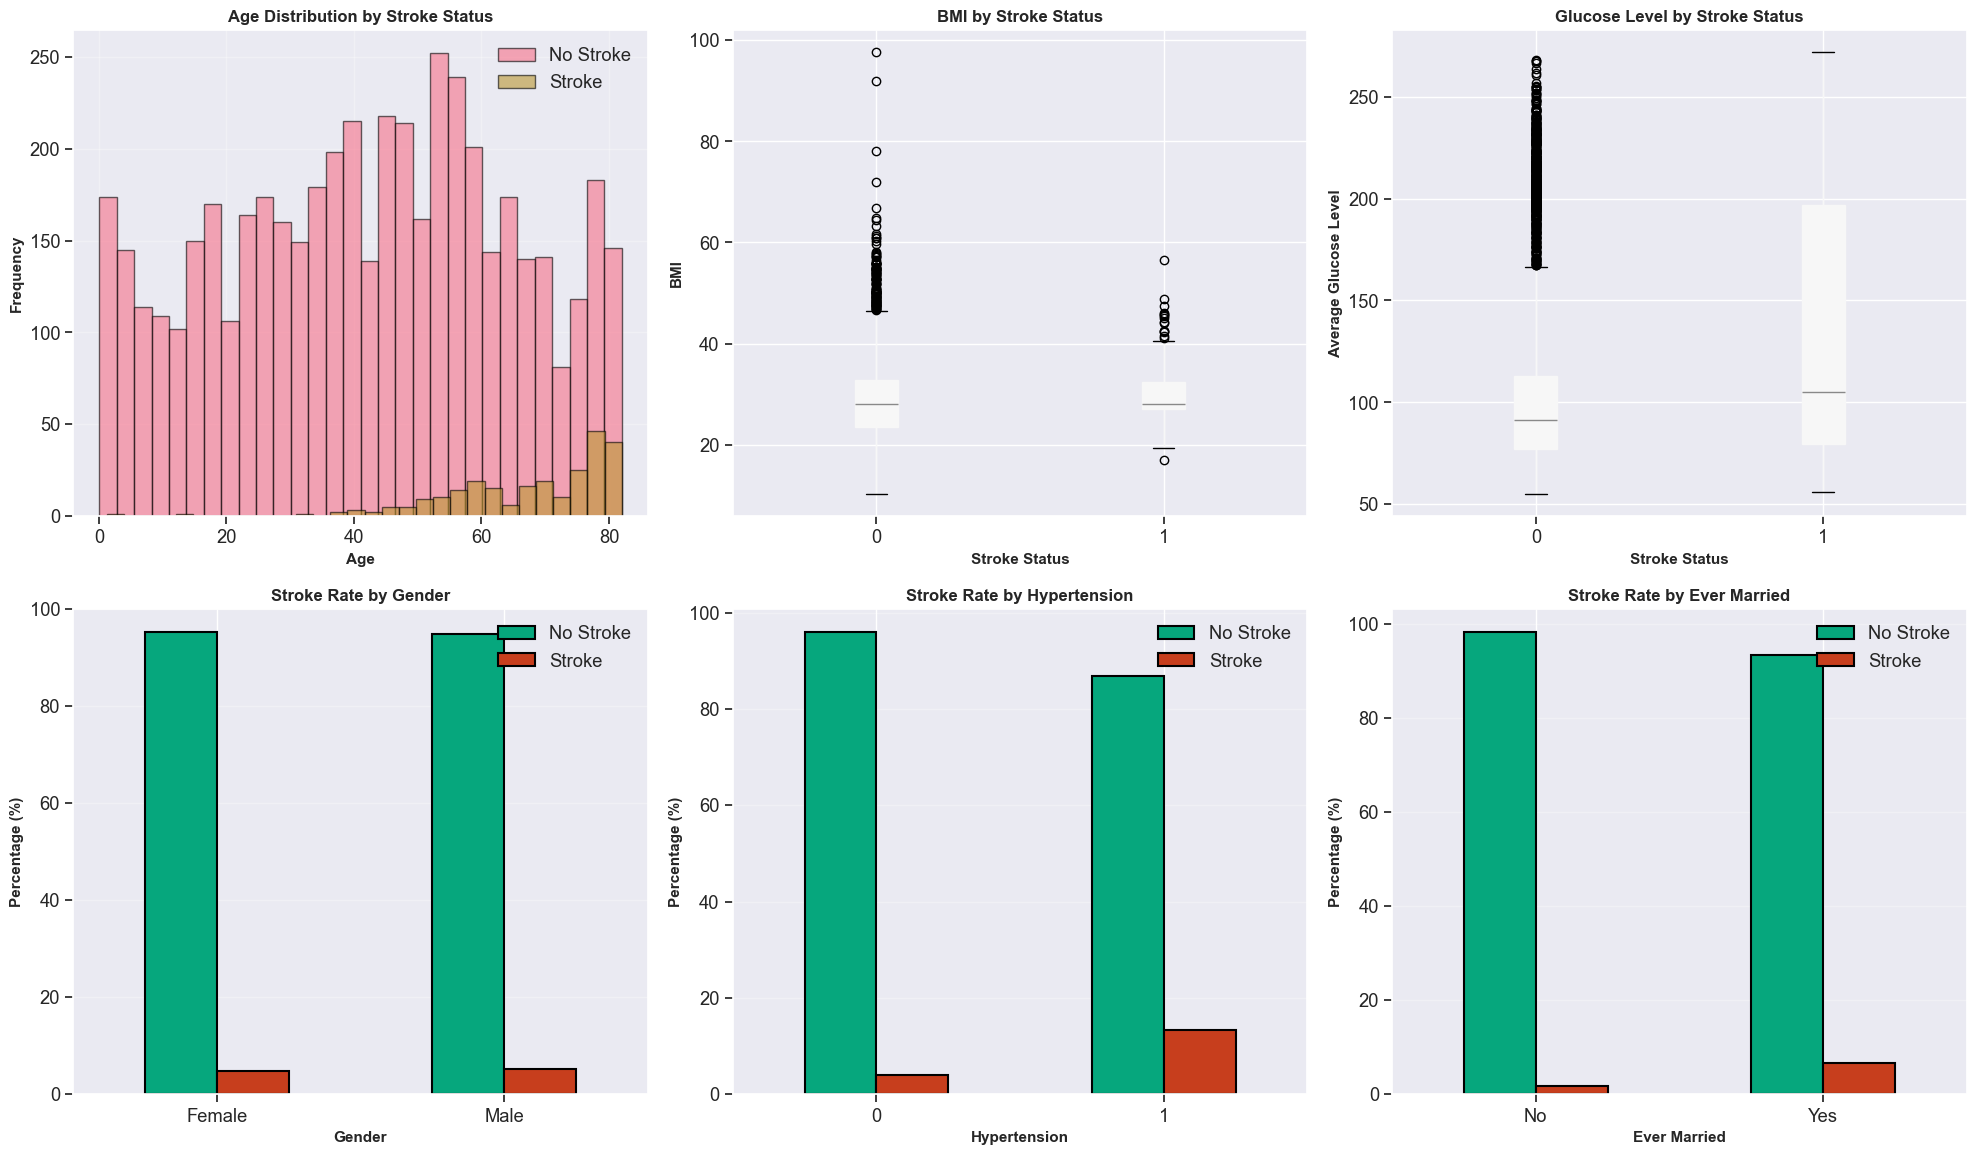

In [10]:
# ==================== VISUALIZATION 5: Bivariate Analysis ====================
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

# Age vs Stroke
for stroke_val in [0, 1]:
    subset = df[df['stroke'] == stroke_val]['age']
    axes[0].hist(subset, bins=30, alpha=0.6,
                label=f'{"No Stroke" if stroke_val == 0 else "Stroke"}',
                edgecolor='black')
axes[0].set_xlabel('Age', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Age Distribution by Stroke Status', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# BMI vs Stroke
df.boxplot(column='bmi', by='stroke', ax=axes[1], patch_artist=True)
axes[1].set_xlabel('Stroke Status', fontsize=11, fontweight='bold')
axes[1].set_ylabel('BMI', fontsize=11, fontweight='bold')
axes[1].set_title('BMI by Stroke Status', fontsize=12, fontweight='bold')
axes[1].get_figure().suptitle('')

# Glucose vs Stroke
df.boxplot(column='avg_glucose_level', by='stroke', ax=axes[2], patch_artist=True)
axes[2].set_xlabel('Stroke Status', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Average Glucose Level', fontsize=11, fontweight='bold')
axes[2].set_title('Glucose Level by Stroke Status', fontsize=12, fontweight='bold')
axes[2].get_figure().suptitle('')

# Categorical features vs Stroke
cat_features = ['gender', 'hypertension', 'ever_married']
for idx, col in enumerate(cat_features, start=3):
    cross_tab = pd.crosstab(df[col], df['stroke'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=False, ax=axes[idx],
                   color=[COLORS['success'], COLORS['danger']],
                   edgecolor='black', linewidth=1.5)
    axes[idx].set_xlabel(col.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Stroke Rate by {col.replace("_", " ").title()}',
                       fontsize=12, fontweight='bold')
    axes[idx].legend(['No Stroke', 'Stroke'])
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('visualization/05_bivariate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# ==================== FEATURE ENGINEERING ====================
# Create dummy variables
df_encoded = pd.get_dummies(df, drop_first=True)
print(f"✓ Categorical variables encoded: {df_encoded.shape[1]} features")

# Separate features and target
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
print(f"✓ Numerical features scaled")


✓ Categorical variables encoded: 16 features
✓ Numerical features scaled


In [12]:
# ==================== HANDLING CLASS IMBALANCE ====================
print("\nHandling Class Imbalance with SMOTE")

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"✓ Original dataset: {X.shape[0]} samples")
print(f"✓ Balanced dataset: {X_balanced.shape[0]} samples")
print(f"✓ Class distribution after SMOTE: {np.bincount(y_balanced)}")


Handling Class Imbalance with SMOTE
✓ Original dataset: 5110 samples
✓ Balanced dataset: 9722 samples
✓ Class distribution after SMOTE: [4861 4861]


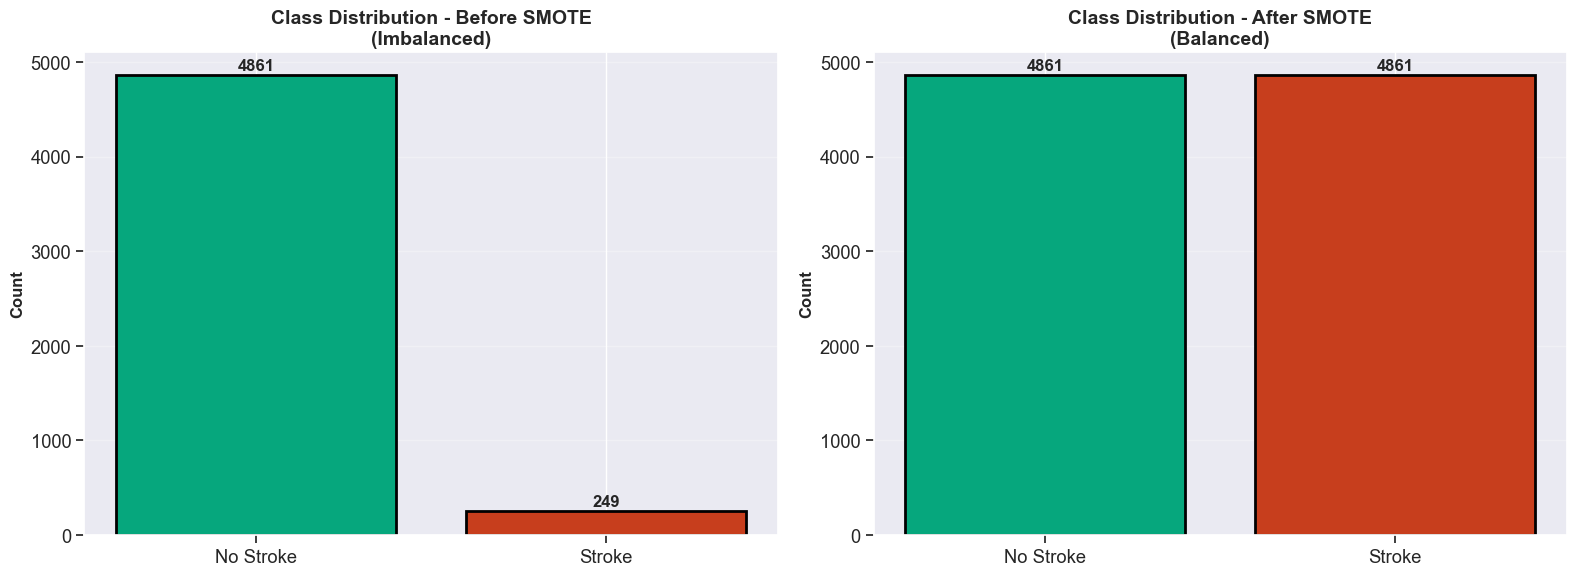

In [13]:
# ==================== VISUALIZATION 6: Before/After SMOTE ====================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before SMOTE
before_counts = y.value_counts()
axes[0].bar(['No Stroke', 'Stroke'], before_counts.values,
            color=[COLORS['success'], COLORS['danger']],
            edgecolor='black', linewidth=2)
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution - Before SMOTE\n(Imbalanced)',
                  fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(before_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold', fontsize=12)

# After SMOTE
after_counts = pd.Series(y_balanced).value_counts()
axes[1].bar(['No Stroke', 'Stroke'], after_counts.values,
            color=[COLORS['success'], COLORS['danger']],
            edgecolor='black', linewidth=2)
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Class Distribution - After SMOTE\n(Balanced)',
                  fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(after_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('visualization/06_smote_balancing.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# ==================== TRAIN-TEST SPLIT ====================
print("\nCreating Train-Test Split")

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=RANDOM_STATE, stratify=y_balanced
)

print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Testing set: {X_test.shape[0]} samples")
print(f"✓ Feature dimensions: {X_train.shape[1]} features")


Creating Train-Test Split
✓ Training set: 7777 samples
✓ Testing set: 1945 samples
✓ Feature dimensions: 15 features


In [15]:
# ==================== MODEL TRAINING ====================
print("\nTraining Machine Learning Models")

# Initialize models
models = {
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric='logloss'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

# Store results
results = {}

for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"TRAINING: {name}")
    print(f"{'='*70}")

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    # Store results
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    print(f"\n✓ Accuracy: {accuracy:.4f}")
    print(f"✓ Precision: {precision:.4f}")
    print(f"✓ Recall: {recall:.4f}")
    print(f"✓ F1-Score: {f1:.4f}")
    print(f"✓ ROC-AUC: {roc_auc:.4f}")
    print(f"✓ CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



Training Machine Learning Models

TRAINING: XGBoost

✓ Accuracy: 0.9388
✓ Precision: 0.9252
✓ Recall: 0.9547
✓ F1-Score: 0.9397
✓ ROC-AUC: 0.9872
✓ CV ROC-AUC: 0.9826 (+/- 0.0018)

TRAINING: Random Forest

✓ Accuracy: 0.8920
✓ Precision: 0.8608
✓ Recall: 0.9352
✓ F1-Score: 0.8964
✓ ROC-AUC: 0.9618
✓ CV ROC-AUC: 0.9560 (+/- 0.0030)



Generating Performance Visualizations


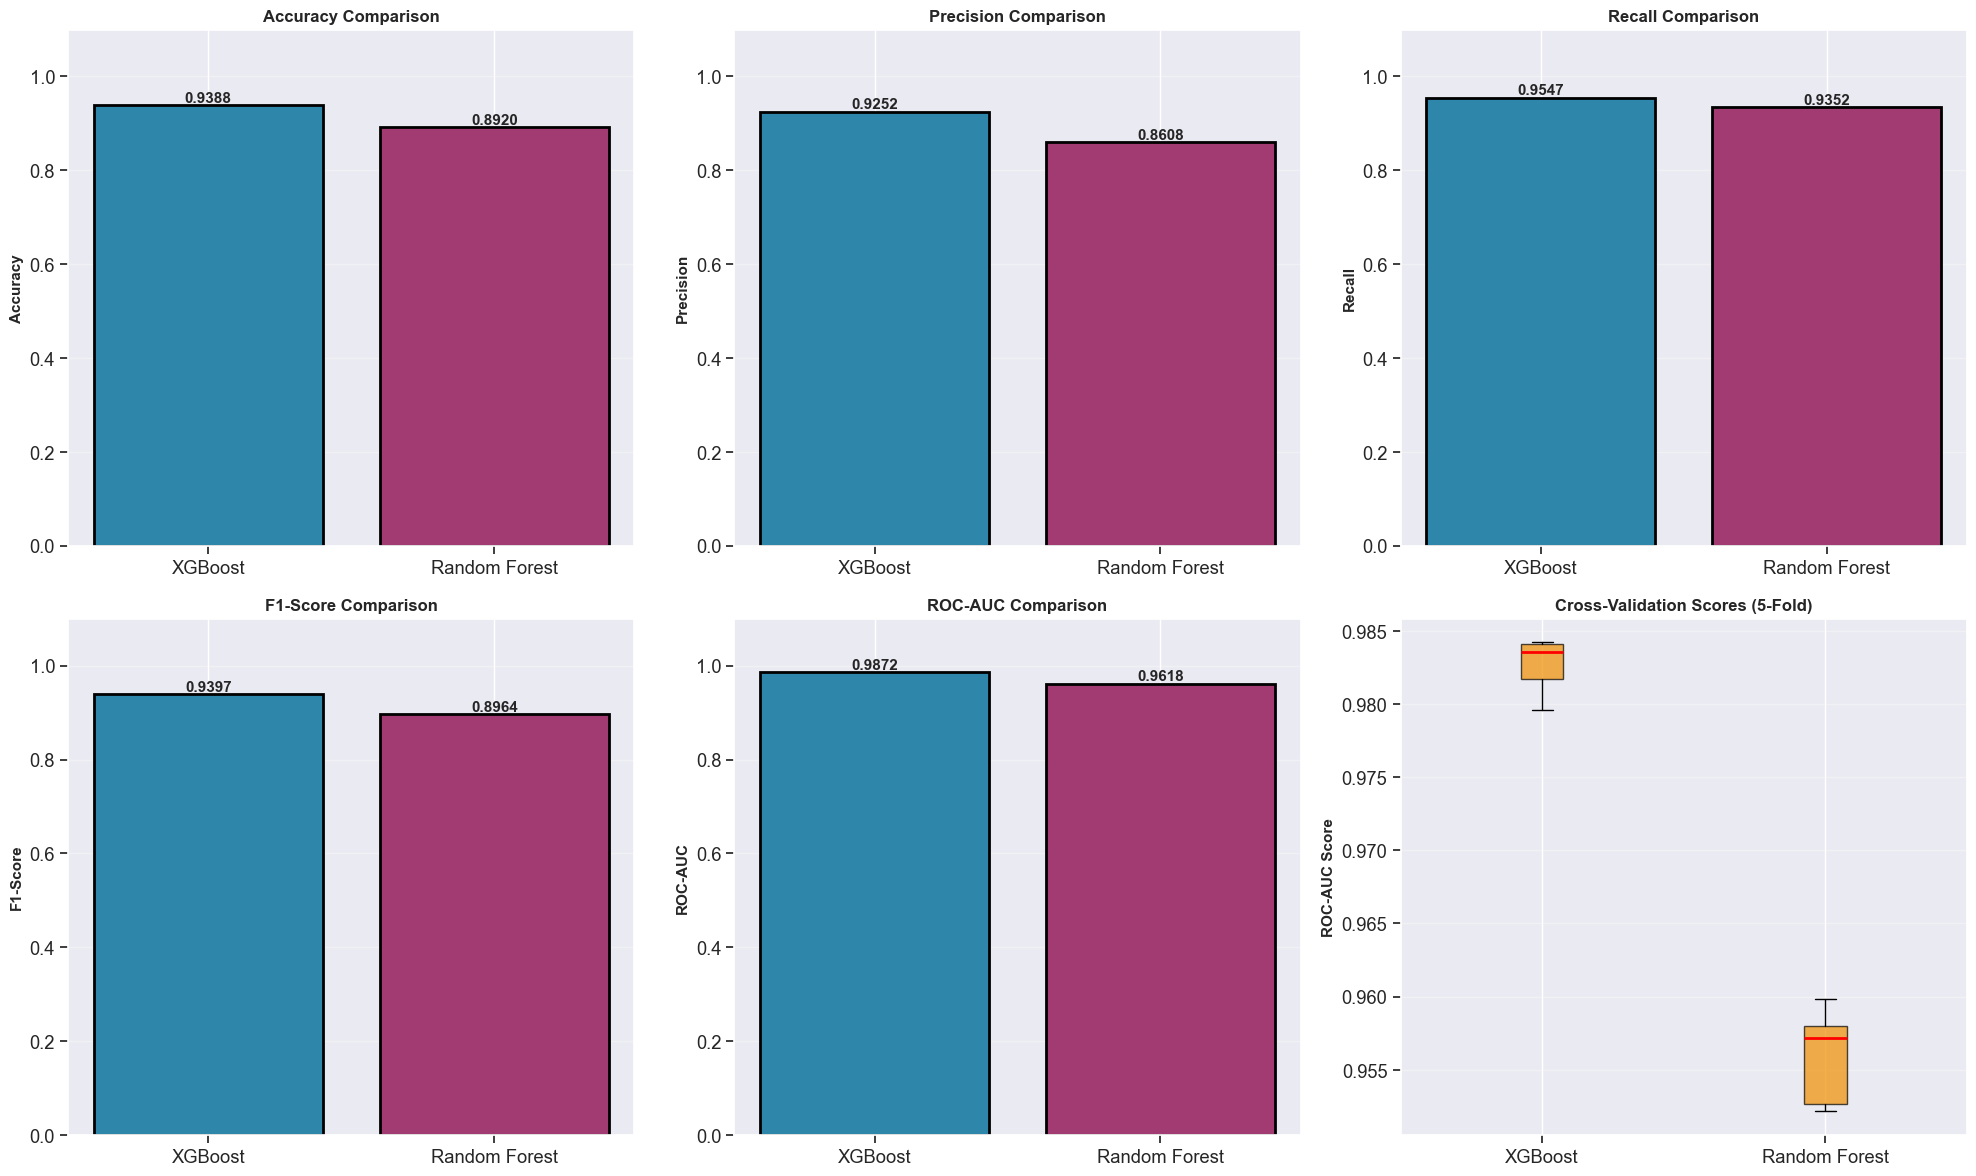

In [16]:
# ==================== VISUALIZATION 7: Model Performance Comparison ====================
print("\nGenerating Performance Visualizations")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Metrics comparison
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    values = [results[model][metric] for model in models.keys()]
    bars = axes[idx//3, idx%3].bar(models.keys(), values,
                                    color=[COLORS['primary'], COLORS['secondary']],
                                    edgecolor='black', linewidth=2)
    axes[idx//3, idx%3].set_ylabel(metric_name, fontsize=11, fontweight='bold')
    axes[idx//3, idx%3].set_title(f'{metric_name} Comparison',
                                   fontsize=12, fontweight='bold')
    axes[idx//3, idx%3].set_ylim([0, 1.1])
    axes[idx//3, idx%3].grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[idx//3, idx%3].text(bar.get_x() + bar.get_width()/2., height,
                                 f'{value:.4f}',
                                 ha='center', va='bottom', fontweight='bold', fontsize=11)

# Cross-validation scores comparison
cv_data = [results[model]['cv_scores'] for model in models.keys()]
bp = axes[1, 2].boxplot(cv_data, labels=models.keys(), patch_artist=True,
                        boxprops=dict(facecolor=COLORS['accent'], alpha=0.7),
                        medianprops=dict(color='red', linewidth=2))
axes[1, 2].set_ylabel('ROC-AUC Score', fontsize=11, fontweight='bold')
axes[1, 2].set_title('Cross-Validation Scores (5-Fold)', fontsize=12, fontweight='bold')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualization/07_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


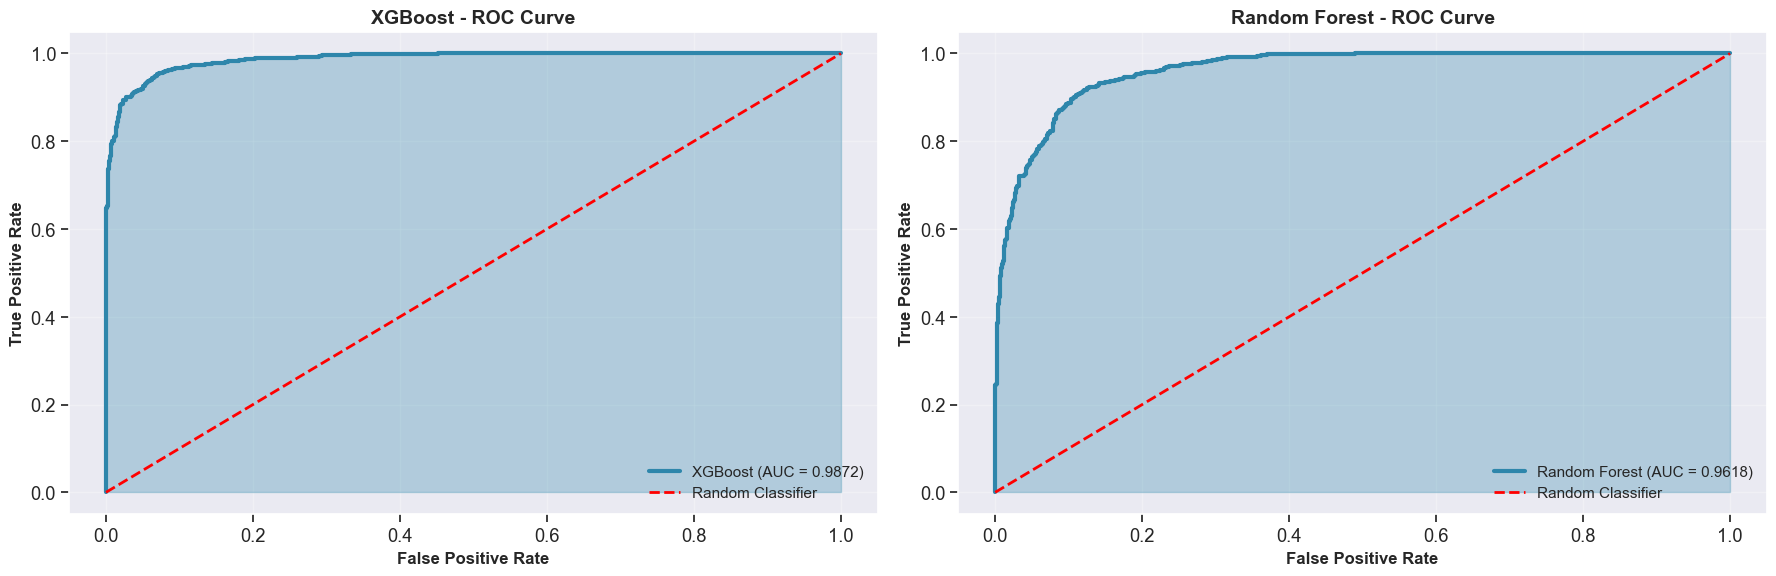

In [17]:

# ==================== VISUALIZATION 8: ROC Curves ====================
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for idx, (name, result) in enumerate(results.items()):
    fpr, tpr, thresholds = roc_curve(y_test, result['y_pred_proba'])

    axes[idx].plot(fpr, tpr, linewidth=3, color=COLORS['primary'],
                   label=f'{name} (AUC = {result["roc_auc"]:.4f})')
    axes[idx].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier')
    axes[idx].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{name} - ROC Curve', fontsize=14, fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=11)
    axes[idx].grid(alpha=0.3)
    axes[idx].fill_between(fpr, tpr, alpha=0.3, color=COLORS['primary'])

plt.tight_layout()
plt.savefig('visualization/08_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

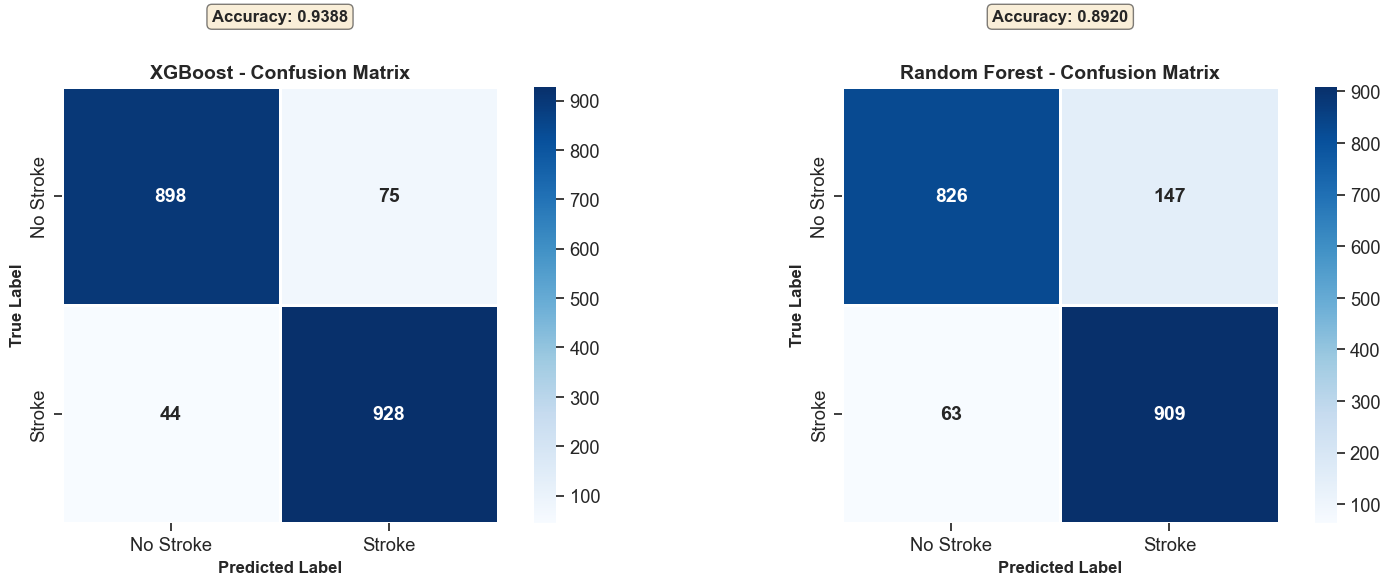

In [18]:
# ==================== VISUALIZATION 9: Confusion Matrices ====================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                square=True, linewidths=2, ax=axes[idx],
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})

    axes[idx].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{name} - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[idx].set_xticklabels(['No Stroke', 'Stroke'])
    axes[idx].set_yticklabels(['No Stroke', 'Stroke'])

    # Add accuracy text
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    axes[idx].text(1, -0.3, f'Accuracy: {accuracy:.4f}',
                   ha='center', fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('visualization/09_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


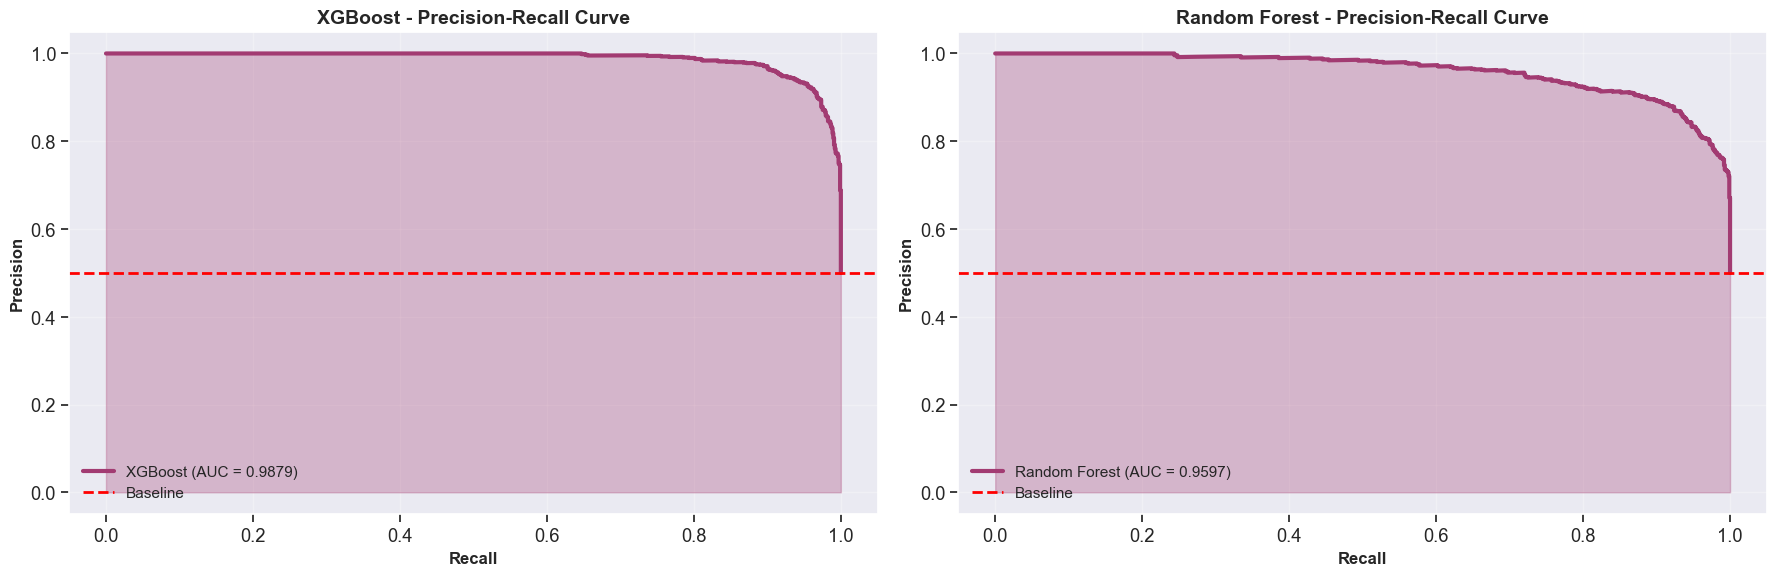

In [19]:
# ==================== VISUALIZATION 10: Precision-Recall Curves ====================
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for idx, (name, result) in enumerate(results.items()):
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    pr_auc = auc(recall_curve, precision_curve)

    axes[idx].plot(recall_curve, precision_curve, linewidth=3,
                   color=COLORS['secondary'],
                   label=f'{name} (AUC = {pr_auc:.4f})')
    axes[idx].axhline(y=0.5, color='r', linestyle='--', linewidth=2,
                      label='Baseline')
    axes[idx].set_xlabel('Recall', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Precision', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{name} - Precision-Recall Curve', fontsize=14, fontweight='bold')
    axes[idx].legend(loc='lower left', fontsize=11)
    axes[idx].grid(alpha=0.3)
    axes[idx].fill_between(recall_curve, precision_curve, alpha=0.3,
                           color=COLORS['secondary'])

plt.tight_layout()
plt.savefig('visualization/10_precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()


Analyzing Feature Importance


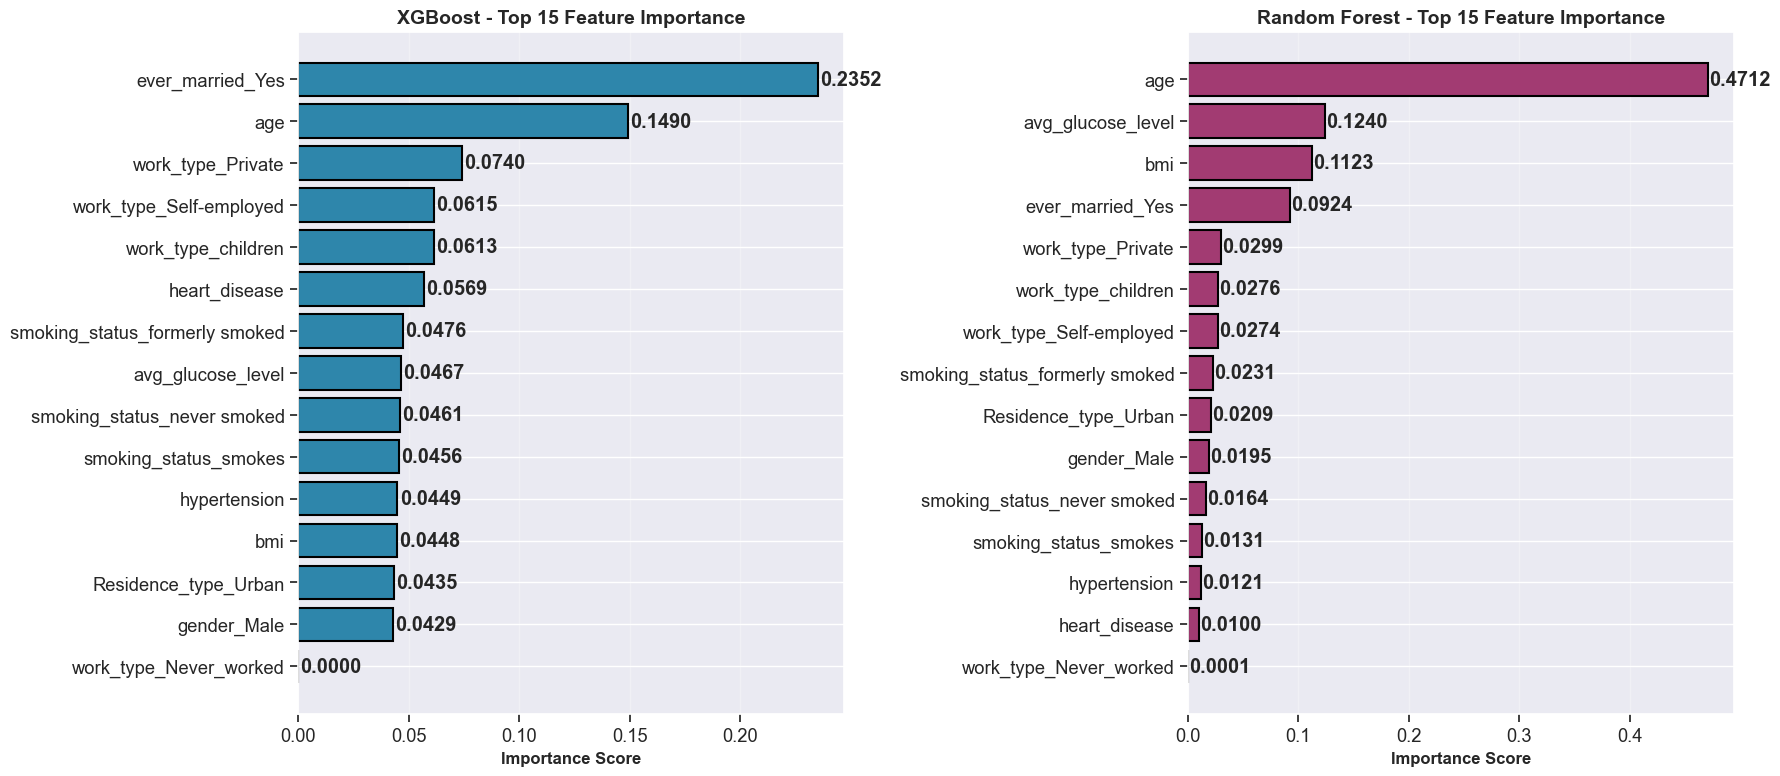

In [20]:
# ==================== VISUALIZATION 11: Feature Importance ====================
print("\nAnalyzing Feature Importance")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# XGBoost Feature Importance
xgb_model = results['XGBoost']['model']
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True).tail(15)

axes[0].barh(feature_importance_xgb['feature'], feature_importance_xgb['importance'],
             color=COLORS['primary'], edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
axes[0].set_title('XGBoost - Top 15 Feature Importance',
                  fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

for i, v in enumerate(feature_importance_xgb['importance'].values):
    axes[0].text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold')

# Random Forest Feature Importance
rf_model = results['Random Forest']['model']
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True).tail(15)

axes[1].barh(feature_importance_rf['feature'], feature_importance_rf['importance'],
             color=COLORS['secondary'], edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
axes[1].set_title('Random Forest - Top 15 Feature Importance',
                  fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(feature_importance_rf['importance'].values):
    axes[1].text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualization/11_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


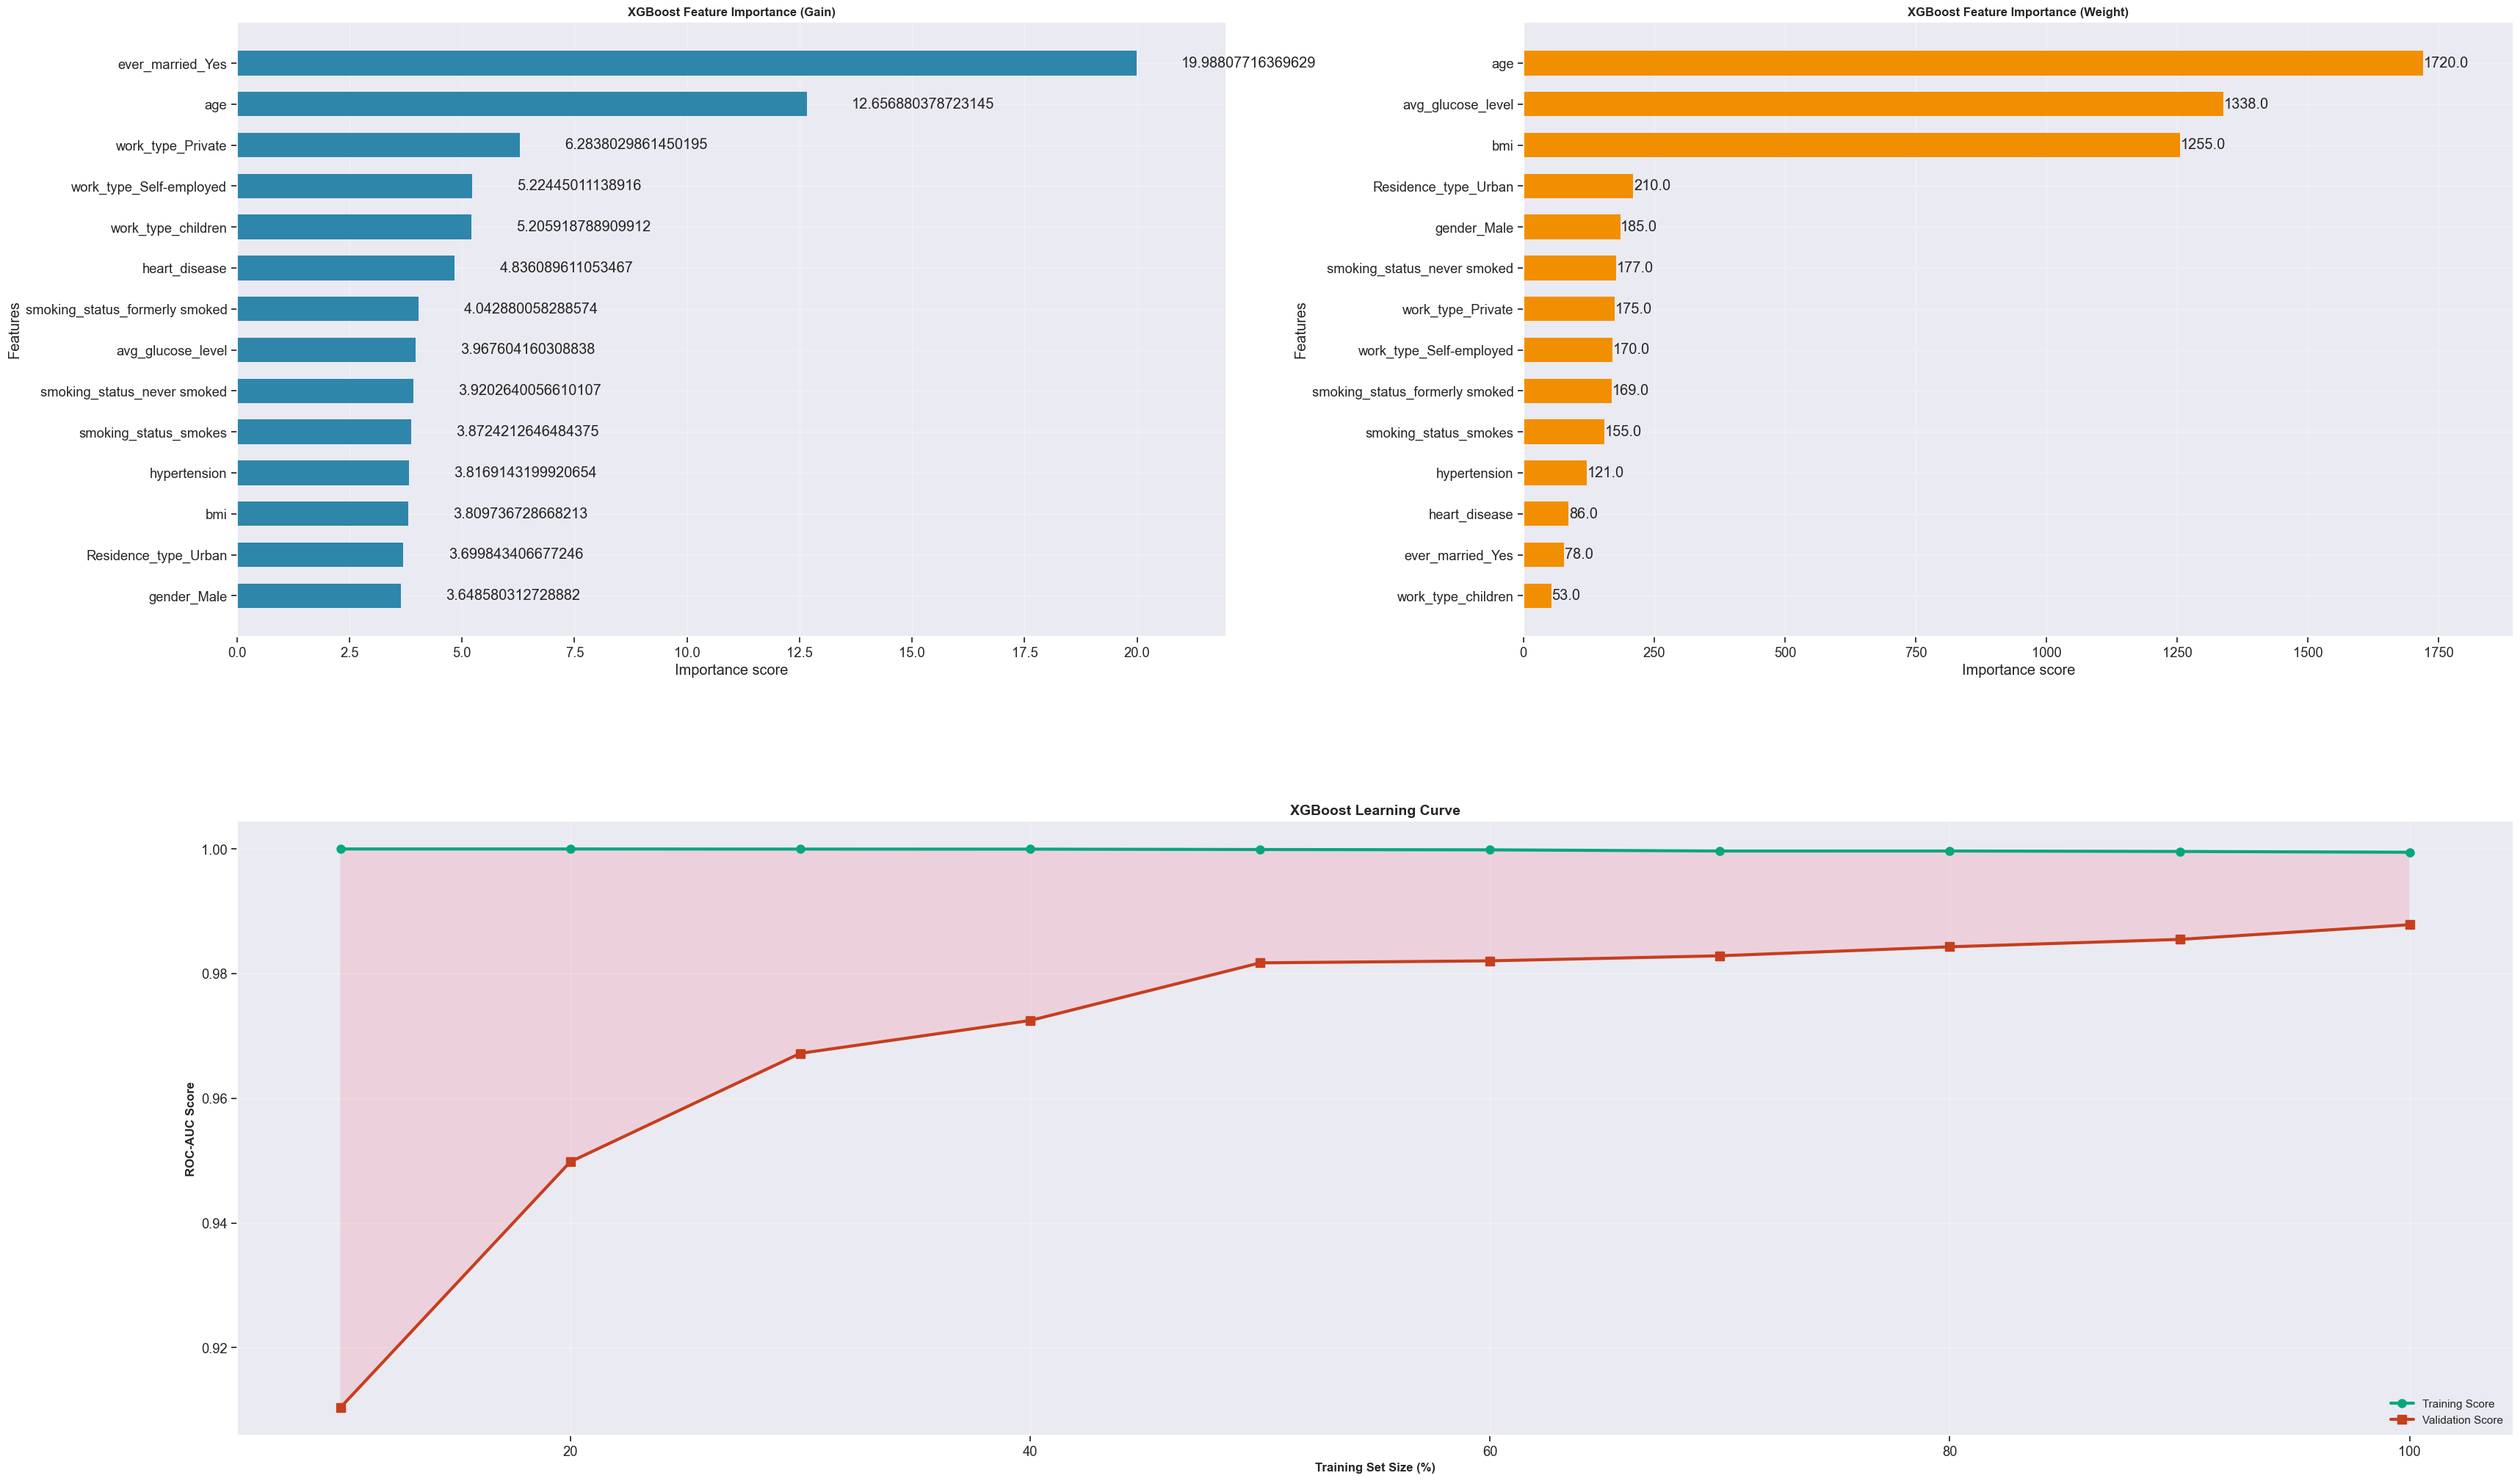

In [21]:
# ==================== VISUALIZATION 12: XGBoost Advanced Visualization ====================
fig = plt.figure(figsize=(40, 25))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# XGBoost built-in importance plot (gain)
ax1 = fig.add_subplot(gs[0, 0])
plot_importance(xgb_model, importance_type='gain', max_num_features=15,
                ax=ax1, color=COLORS['primary'], height=0.6)
ax1.set_title('XGBoost Feature Importance (Gain)', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# XGBoost built-in importance plot (weight)
ax2 = fig.add_subplot(gs[0, 1])
plot_importance(xgb_model, importance_type='weight', max_num_features=15,
                ax=ax2, color=COLORS['accent'], height=0.6)
ax2.set_title('XGBoost Feature Importance (Weight)', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

# Learning curve simulation
ax3 = fig.add_subplot(gs[1, :])
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
test_scores = []

for train_size in train_sizes:
    size = int(len(X_train) * train_size)
    temp_model = XGBClassifier(n_estimators=100, random_state=RANDOM_STATE)
    temp_model.fit(X_train[:size], y_train[:size])

    train_pred = temp_model.predict_proba(X_train[:size])[:, 1]
    test_pred = temp_model.predict_proba(X_test)[:, 1]

    train_scores.append(roc_auc_score(y_train[:size], train_pred))
    test_scores.append(roc_auc_score(y_test, test_pred))

ax3.plot(train_sizes * 100, train_scores, 'o-', linewidth=3,
         color=COLORS['success'], label='Training Score', markersize=8)
ax3.plot(train_sizes * 100, test_scores, 's-', linewidth=3,
         color=COLORS['danger'], label='Validation Score', markersize=8)
ax3.set_xlabel('Training Set Size (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax3.set_title('XGBoost Learning Curve', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(alpha=0.3)
ax3.fill_between(train_sizes * 100, train_scores, test_scores, alpha=0.2)

plt.savefig('visualization/12_xgboost_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# ==================== FINAL RESULTS SUMMARY ====================
print("\n Final Results Summary")

print(f"\n{'='*80}")
print("FINAL MODEL PERFORMANCE SUMMARY")
print(f"{'='*80}")

summary_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()],
    'CV Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()]
})

print(summary_df.to_string(index=False))

# Determine best model
best_model = max(results.items(), key=lambda x: x[1]['roc_auc'])
print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model[0]}")
print(f"ROC-AUC SCORE: {best_model[1]['roc_auc']:.4f}")
print(f"{'='*70}")

# Classification reports
for name in results.keys():
    print(f"\n{'='*70}")
    print(f"{name} - CLASSIFICATION REPORT")
    print(f"{'='*70}")
    print(classification_report(y_test, results[name]['y_pred'],
                                target_names=['No Stroke', 'Stroke']))



 Final Results Summary

FINAL MODEL PERFORMANCE SUMMARY
        Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV Mean   CV Std
      XGBoost  0.938817   0.925224 0.954733  0.939747 0.987185 0.982644 0.001752
Random Forest  0.892031   0.860795 0.935185  0.896450 0.961766 0.955971 0.003046

BEST MODEL: XGBoost
ROC-AUC SCORE: 0.9872

XGBoost - CLASSIFICATION REPORT
              precision    recall  f1-score   support

   No Stroke       0.95      0.92      0.94       973
      Stroke       0.93      0.95      0.94       972

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945


Random Forest - CLASSIFICATION REPORT
              precision    recall  f1-score   support

   No Stroke       0.93      0.85      0.89       973
      Stroke       0.86      0.94      0.90       972

    accuracy                           0.89      1945
   macro avg       0.89      0.89      0